In [66]:
import numba
import time
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

lendo conj. dados

In [32]:
data = pd.read_csv('dataset\\sleeptime_prediction_dataset.csv')
data.head(3)

,WorkoutTime,ReadingTime,PhoneTime,WorkHours,CaffeineIntake,RelaxationTime,SleepTime
0,1.12,0.52,3.29,7.89,216.08,0.75,3.45
1,2.85,0.49,4.22,5.03,206.18,0.67,4.88
2,2.20,1.81,4.04,9.23,28.73,0.35,3.61


In [33]:
data.shape

(2000, 7)

## Previsão de tempo de sono
1) Ajuste um modelo linear da forma
$$
y = a_0 + a_1 x_1 + a_2 x_2 + \ldots + a_m x_m,
$$
onde $y$ é o tempo de sono e $x_i$ são as variáveis independentes (colunas do dataset).

Resposta:

$b$=É o valor previsto

$y$=É o valor real

$a$ = $[a_0, a_1, ...., a_n]$ ,É o vetor dos coeficientes do modelo incluindo o interceptor

$M$ = Matriz das carateristicas(features), no qual adciona a coluna do intercepto($a_0$)

$$
b = M\cdot a 
$$

In [34]:
# Resolucao padrão do numpy para essa equação
@numba.jit(nopython=True)
def modeloPadrão(M, b):
    return  np.linalg.inv(np.dot(M.T, M)) @ M.T @ b,

In [35]:
# Matriz de caracteristicas/Independente
X = data.drop(columns=['SleepTime']).values.astype(np.float32)

# Matriz do valor real
y = data['SleepTime'].values.astype(np.float32).reshape(-1, 1)

In [36]:
M = np.concatenate((np.ones((X.shape[0],1), dtype=np.float32), X), axis=1)

In [37]:
M[0, :]

array([  1.  ,   1.12,   0.52,   3.29,   7.89, 216.08,   0.75],
      dtype=float32)

> Primeira coluna é do inteceptor

In [38]:
b = y

2) Escreva o sistema linear $M a = b$ associado aos mínimos quadrados que representa o modelo ajustado (lembre-se que as variáveis do problema de ajuste são os coeficientes $a_i$ e os dados são os valores de $x_i$ e $y$).


* O objetivo é encontrar $\alpha$ que minimiza o erro onde:
$$
E = ||b - M\cdot a||^2 =  (b - Ma)^T (b-Ma) = b^Tb - 2a^TX^Ty + a^T M^T Ma$$

* Deriva em relação a $a$:
$$
\frac{∂E}{∂a} = -2M^Tb + 2M^TMa = 0
$$

* Resolve 
$$M^TMa =M^Tb $$

Observação: $A=M^TM$ o $b = M^Tb$

**Usando decomposição QR:**

1. $X^T X b = X^T y$
2. $(QR)^T (QR) b = (QR)^T y$
3. $R^T (Q^T Q) R b = R^T Q^T y$
4. $R^T R b = R^T Q^T y$
5. $(R^T)^{-1} R^T R b = (R^T)^{-1} R^T Q^T y$
5. $R b = Q^T y$
   * $\alpha = Q^T y$ 
6.  $R b = \alpha$

In [39]:
def decomposicaoQR(A):
    row, col = A.shape

    if col > row:
        return 0
    
    # Inicializando as matrizes Q e R
    Q = np.zeros(shape=(row, col), dtype=np.float32)
    R = np.zeros(shape=(col, col), dtype=np.float32)
    u = 0

    for i in range(col):
        u = A[:, i]
        for j in range(i):
            R[j, i] = np.dot(Q[:, j], A[:, i])
            u -= np.multiply(R[j, i] , Q[:, j])

        R[i, i] = np.linalg.norm(u).astype(np.float32)
        
        if R[i, i] == 0: return 0

        Q[:, i] = np.divide(u , R[i, i]).astype(np.float32)
    return Q, R

def regressaoQR(M, b):
    M_ = M.copy()
    Q, R = decomposicaoQR(M_)

    alpha = np.dot(Q.T, b)

    norm_ = np.linalg.norm(np.dot(Q,Q.T) - np.eye(Q.shape[0]), "fro")
    print("Norm fro : ", norm_)
    
    return np.linalg.solve(R, alpha)

**Usando decomposição LU:**
1. $M^T M a = M^T b$
2. $A a = M^T b$
3. $LU a = M^T b$
4. $L z = M^T b$
5. $U a = z$

In [40]:
def decomposicaoLU(M):
    A = np.dot(M.T, M)
    
    L = np.diag(np.ones(A.shape[1]))
    U = np.copy(L)

    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if i<=j:
                U[i, j] = A[i, j] - np.sum(L[i, :j] * U[:j, j])
            if i >j:
                L[i, j] =  (A[i, j] - np.sum(L[i, :i] * U[:i, j])) / U[j, j]
                
    return L, U

def regressaoLU(M, b):
    L, U = decomposicaoLU(M)
    y = np.dot(M.T, b)
    x = np.linalg.solve(L, y)
    x = np.linalg.solve(U, x)
    return x

Função de predição

In [41]:
# função retorna o valor predito pelo modelo
def predict(x, coef):
    return np.ravel(np.dot(x, coef))

3) Separe seus dados em 80% para treinamento e 20% para teste. Resolva o sistema linear utilizando dois métodos de sua escolha e apenas os dados de treinamento.

In [42]:
# Essa função divide dados de train e test
def train_test(X , y, trainSize=0.80, randomState=42):
    N, _ = X.shape
    # Indeces
    index = np.arange(0, N)

    # definindo o tamanho de instancias do dados de train
    sizeTrain = int(N*trainSize)

    # Seleciona indices aleatorios 
    trainIndex = np.random.RandomState(randomState).choice(index, size=sizeTrain)

    # Pega as instancias de treinamento
    train = ( X[trainIndex, :],  y[trainIndex, :] )

    # Pega os indices de teste
    testIndex = np.setdiff1d(index, trainIndex, assume_unique=True)

    #  ====> Verifica os valores que não estão contido em ambos array
    test = ( X[testIndex, :], y[testIndex, :] )

    # Retorna os dados de treinamento e teste
    return train[0], train[1], test[0], test[1] 

In [43]:
xtrain, ytrain, xtest, ytest = train_test(M, b, trainSize=0.8, randomState=1)

In [67]:
tempo_execucao = {
    'QR': 0,
    'LU': 0,
    'QR_Poly': 0,
    'LU_Poly': 0
}

In [68]:
# Parametros do modelo QR
start_ = time.time() # Inicia o cronometro
coefQR = regressaoQR(xtrain, ytrain)
end_ = time.time()   # Para o cronometro
tempo_execucao['QR'] = end_ - start_


# Parametros do modelo LU
start_ = time.time()
coefLU = regressaoLU(xtrain, ytrain)
end_ = time.time()

tempo_execucao['LU'] = end_ - start_

Norm fro :  37.282703788329606


4. Calcule o erro resíduo no conjunto de treinamento e no conjunto de teste.

In [47]:
def residuals(x, coef, ytrue, func = None):
    return func(x, coef) - ytrue

In [48]:
trainResidualQR = residuals(xtrain, coefQR, ytrain, func=predict)

trainResidualLU = residuals(xtrain, coefLU, ytrain, func=predict)

In [49]:
testResidualQR = residuals(xtest, coefQR, ytest, func=predict)

testResidualLU = residuals(xtest, coefLU, ytest, func=predict)

5) Compare os resultados dos dois métodos.

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [51]:
def metricas(pred, true, method=''):
    print("Metricas para o método ", method)
    print("RMSE...: ", mean_squared_error(true, pred))
    print("MAE....: ", mean_absolute_error(true, pred))
    print("R2.....: ", r2_score(true, pred))

In [52]:
metricas(predict(xtrain, coefQR), ytrain, 'QR')

Metricas para o método  QR
RMSE...:  3.6209126
MAE....:  0.6551053
R2.....:  0.2420777678489685


In [53]:
metricas(predict(xtrain, coefLU), ytrain, 'LU')

Metricas para o método  LU
RMSE...:  3.6209123929160136
MAE....:  0.6551053865234284
R2.....:  0.24207774194183018


6) Faça um histograma dos resíduos no conjunto de treinamento e no conjunto de teste.

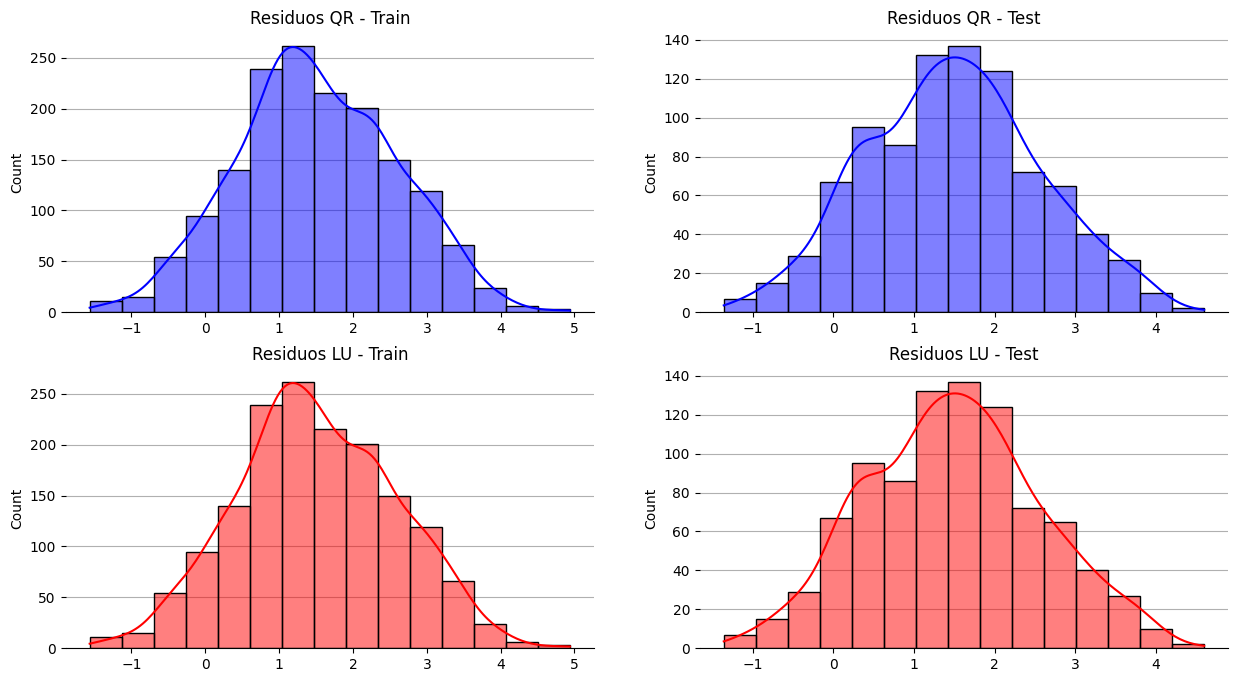

In [54]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))


# Residuos QR
sea.histplot(trainResidualQR[0], bins=15, color='blue', alpha=0.5, ax=ax[0, 0], kde=True)
ax[0][0].set_title('Residuos QR - Train')
ax[0][0].spines[['right', 'top', 'left']].set_visible(False)
ax[0][0].grid(True, axis='y')
ax[0][0].set_axisbelow(True)



sea.histplot(testResidualQR[0], bins=15, color='blue', alpha=0.5, ax=ax[0, 1], kde=True)
ax[0][1].set_title('Residuos QR - Test')
ax[0][1].spines[['right', 'top', 'left']].set_visible(False)
ax[0][1].grid(True, axis='y')
ax[0][1].set_axisbelow(True)


# Residuos LU
sea.histplot(testResidualLU[0], bins=15, color='red', alpha=0.5, ax=ax[1, 1], kde=True)
ax[1][1].set_title('Residuos LU - Test')
ax[1][1].grid(True, axis='y')
ax[1][1].set_axisbelow(True)
ax[1][1].spines[['right', 'top', 'left']].set_visible(False)

sea.histplot(trainResidualLU[0], bins=15, color='red', alpha=0.5, ax=ax[1, 0], kde=True)
ax[1][0].set_title('Residuos LU - Train')
ax[1][0].spines[['right', 'top', 'left']].set_visible(False)
ax[1][0].grid(True, axis='y')
ax[1][0].set_axisbelow(True)
plt.show()


In [55]:
from scipy.stats import shapiro

# Verificando a normalidade dos residuos com o teste de Shapiro
for i in [trainResidualLU, trainResidualQR, testResidualLU, testResidualQR]:
    p, h = shapiro(i[0])

    if h > 0.05: # Se o p-valor for maior que 0.05 , aceito a hipotese nula
        print(f"A distribuição não segue a normalidade p-valor {h:.4f}")
    else: # Se o p-valor for menor que 0.05, rejeito a hipotese nula e aceito h1
        print(f"A distribuição segue a normalidade p-valor {h:.4f}")

A distribuição segue a normalidade p-valor 0.0083
A distribuição segue a normalidade p-valor 0.0083
A distribuição segue a normalidade p-valor 0.0157
A distribuição segue a normalidade p-valor 0.0157


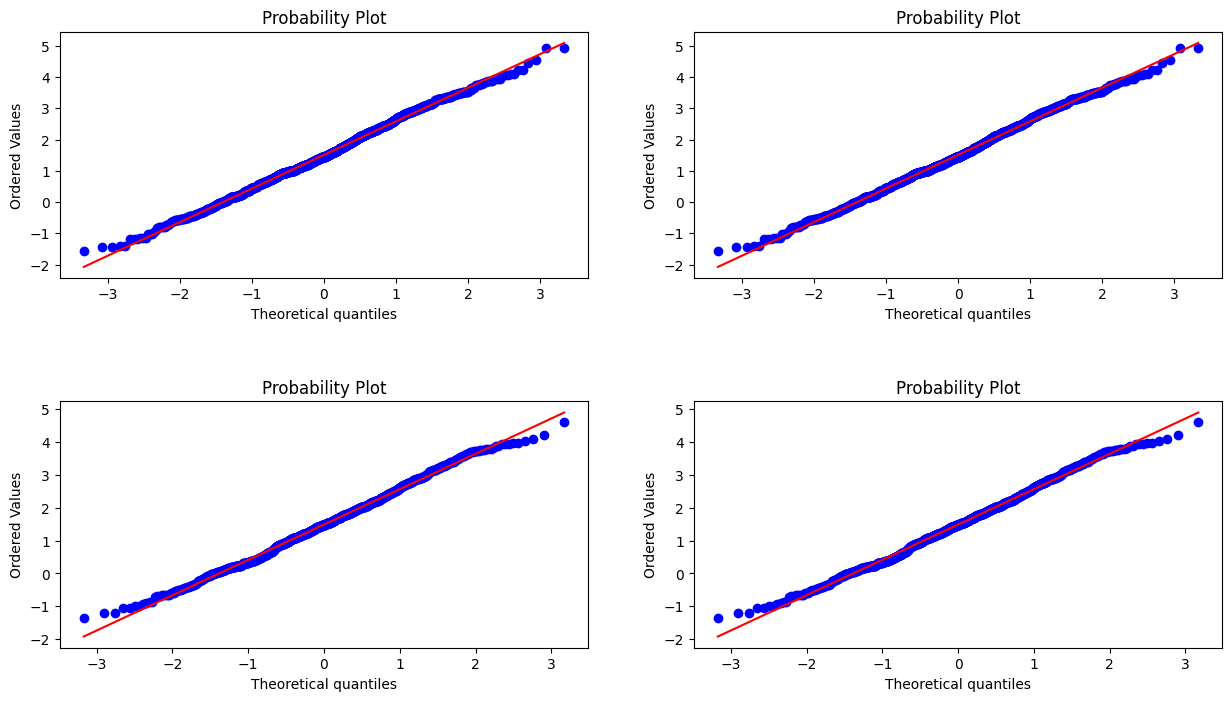

In [56]:
from scipy.stats import probplot # probplot verifica a normalidade

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.subplots_adjust(hspace=0.5)

# Residuos QR
data = [trainResidualLU, trainResidualQR, testResidualLU, testResidualQR]

# Probplot para os residuos verificando a normalidade
for i, axis in zip(data, ax.flatten()): 
    probplot(i[0], plot=axis)

plt.show()

7) Ajuste um modelo do tipo polinomial de grau 2 para prever o tempo de sono.

In [57]:
from sklearn.preprocessing import PolynomialFeatures

In [63]:
x = PolynomialFeatures(degree=4, include_bias=False).fit_transform(X)
x = np.concatenate((np.ones((x.shape[0], 1)), x), axis=1)

In [64]:
xtrain, ytrain, xtest, ytest = train_test(x, b, trainSize=0.8, randomState=1)

In [70]:
start_ = time.time()
coefQR_ = regressaoQR(xtrain, ytrain)
end_   = time.time()

tempo_execucao['QR_Poly'] = end_ - start_


start_ = time.time()
coefLU_ = regressaoLU(xtrain, ytrain)
end_   = time.time()

tempo_execucao['LU_Poly'] = end_ - start_

Norm fro :  37.282703788329606


8. Compare os resultados do modelo polinomial com o modelo linear.

In [71]:
pd.DataFrame(tempo_execucao, index=['Tempo de execução'])

,QR,LU,QR_Poly,LU_Poly
Tempo de execução,0.613663,0.424356,0.787072,0.292614


9. Faça 5 slides para apresentar o seu trabalho.